In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
tfd = tfp.distributions
import matplotlib.pyplot as plt

In [13]:
# Start by defining a batch of two univariate Gaussians, then
# combined them into a bivariate Gaussian with independent components

locs = [-1, 1]
scales = [0.5, 1.]
batch_normals = tfd.Normal(loc=locs, scale=scales)

/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


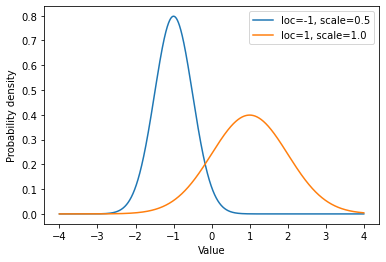

In [18]:
# Univariate density functions

import seaborn as sns

t = np.linspace(-4, 4, 10000)
densities = batch_normals.prob(np.repeat(t[:, np.newaxis], 2, axis=1)) # each column is a vector of densities

sns.lineplot(t, densities[:,0], label='loc={}, scale={}'.format(locs[0], scales[0]))
sns.lineplot(t, densities[:,1], label='loc={}, scale={}'.format(locs[1], scales[1]))
plt.ylabel('Probability density')
plt.xlabel('Value')
plt.legend()
plt.show()

In [19]:
# Check their batch_shape and event_shape

batch_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [22]:
# Use Independent to conver the batch shape to the event shape

bivariate_normal_from_Independent = tfd.Independent(batch_normals,
                                                   reinterpreted_batch_ndims=1)

In [24]:
# Note that dimension from batch_shape has shifted to event_shape

bivariate_normal_from_Independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


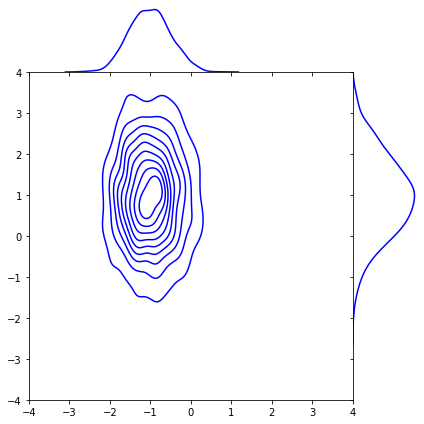

In [25]:
# Create a plot showing joint density contours and marginal density functions

samples = bivariate_normal_from_Independent.sample(1000)
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x1, x2, kind='kde', space=0, color='b', xlim=[-4,4], ylim=[-4,4])

In [28]:
# Use MultivariateNormalDiag to create the equivalent distribution
# Note that diaginal covariance matrix => independence (for the multivariate normal dist)

bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc=locs, scale_diag=scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


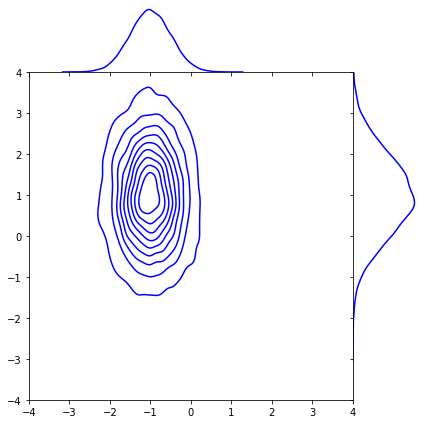

In [30]:
# Plot the joint density function of bivariate normal from Multivariate
# Refer back to bivariate_normal_from_Independent to show that the plot is the same

samples = bivariate_normal_from_Multivariate.sample(10000)
x1 = samples[:,0]
x2 = samples[:,1]
sns.jointplot(x1, x2, kind='kde', space=0, color='b', xlim=[-4, 4], ylim=[-4, 4]);

#### Shifting batch dimensions to event dimensions using `reinterpreted_batch_ndims`

In [32]:
# Demonstrate use of reinterpreted_batch_ndims
# By default all batch dims except the first are transferred to event dims

loc_grid =[[-100., -100.],
          [100., 100.],
          [0., 0.]]
scale_grid = [[1., 10.],
             [1., 10.],
             [1., 1.]]

normals_batch_3by2_event1 = tfd.Normal(loc=loc_grid, scale=scale_grid)

In [33]:
# Highlight batch_shape

normals_batch_3by2_event1

<tfp.distributions.Normal 'Normal' batch_shape=[3, 2] event_shape=[] dtype=float32>

In [35]:
# We now have a batch of 3 bivariate normal distributions,
# each parameterized by a column of our original parameter grid

normals_batch_3_event_2 = tfd.Independent(normals_batch_3by2_event1)
normals_batch_3_event_2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[3] event_shape=[2] dtype=float32>

In [36]:
# Evaluate log_prob

normals_batch_3_event_2.log_prob(value=[[-10,10],
                                       [100, 100],
                                       [1.,1.]])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-4.1146406e+03, -4.1404624e+00, -2.8378770e+00], dtype=float32)>

In [38]:
# Can interpret _all_ batch dimensions as event dimensions

normals_batch_1_event_3by2 = tfd.Independent(normals_batch_3by2_event1,
                                            reinterpreted_batch_ndims=2)

In [39]:
normals_batch_1_event_3by2

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[3, 2] dtype=float32>

In [41]:
# Evaluate log_prob

normals_batch_1_event_3by2.log_prob(value=[[-10,10],
                                       [100, 100],
                                       [1.,1.]])

<tf.Tensor: shape=(), dtype=float32, numpy=-4121.619>

#### Using Independent to build a Naive Bayes classifier

#### Introduction to `newsgroups` data set

In this tutorial, just load the dataset, fetch train/test splits, probably choose a subset of the data.

Construct the class conditional feature distribution (with Independent, using the Naive Bayes assumption) and sample from it.

We can just use the ML estimates for parameters, in later tutorials we will learn them.

In [42]:
# Convenience function for retrieving the 20 newsgroups data set

# Usenet was a forerunner to modern internet forums
# Users could post and read articles
# Newsgroup corresponded to a topic
# Example topics in this data set: IBM computer hardware, baseball
# Our objective is to use an article's contents to predict its newsgroup,
# a 20-class classification problem.

# 18000 newsgroups, posts on 20 topics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

In [43]:
# Get the train data

newsgroup_data = fetch_20newsgroups(data_home='20_Newsgroup_Data/', subset='train')

In [45]:
# More information about the data set

print(newsgroup_data['DESCR'])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality 

In [47]:
# Example article

print(newsgroup_data['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [48]:
# Associated label

newsgroup_data['target'][0]

7

In [49]:
# Name of label

newsgroup_data['target_names'][7]

'rec.autos'

In [52]:
# Preprocessing boilerplate

n_documents = len(newsgroup_data['data'])

count_vectorizer = CountVectorizer(input='content', binary=True,
                                  max_df=0.25, min_df=1.01/n_documents) # ignore common words and words that appear only once

binary_bag_of_words = count_vectorizer.fit_transform(newsgroup_data['data']) # input is a list of strings

In [53]:
# Check shape

binary_bag_of_words.shape

(11314, 56365)

In [54]:
# Check that the fit has been successful

count_vectorizer.inverse_transform(binary_bag_of_words[0,:])

[array(['lerxst', 'wam', 'umd', 'where', 'thing', 'car', 'rac3',
        'maryland', 'college', 'park', '15', 'wondering', 'anyone',
        'could', 'enlighten', 'saw', 'day', 'door', 'sports', 'looked',
        'late', '60s', 'early', '70s', 'called', 'bricklin', 'doors',
        'were', 'really', 'small', 'addition', 'front', 'bumper',
        'separate', 'rest', 'body', 'tellme', 'model', 'name', 'engine',
        'specs', 'years', 'production', 'made', 'history', 'whatever',
        'info', 'funky', 'looking', 'please', 'mail', 'thanks', 'il',
        'brought', 'neighborhood'], dtype='<U80')]

In [55]:
# Dict that will be useful later

inv_vocabulary = {value: key for key,value in count_vectorizer.vocabulary_.items()}

#### A Naive Bayes classifier for newsgroup

Each feature vector $x$ is a list of indicators for whether a word appears in the article. $x_i$ is 1 if the $i$th word appears, and 0 otherwise. `inv_vocabulary` matches word indices $i$ to words.

Each label $y$ is a value in $0, 1, \ldots, 19$.

The parts of a naive Bayes classifier for this problem can be summarised as:  


- A probability distribution for the feature vector by class, $p(x|y = j)$ for each $j = 0, 1, \ldots, 19$. These probability distributions are assumed to have independent components: we can factorize the joint probability as a product of marginal probabilities
\begin{equation}
    p(x|y = j) = \prod_{i=1}^d p(x_i|y = j)
\end{equation}
These marginal probability distributions are Bernoulli distributions, each of which has a single parameter $\theta_{ji} := p(x_i = 1|y = j)$. This parameter is the probability of observing word $i$ in an article of class $j$. 

- We will use the Laplace smoothed maximum likelihood estimate to compute these parameters. Laplace smoothing involves adding small counts to every feature for each class. Else, if a feature did not appear in the training set of a class, but then we observed it in our test data the log probability would be undefined.

- A collection of class prior probabilities $p(y = j)$. These will be set by computing the class base rates in the training set.  


- A function for computing the probability of class membership via Bayes' theorem:  

\begin{equation}
    p(y = j|x) = \frac{p(x|y = j)p(y = j)}{p(x)}
\end{equation}

In [56]:
# Compute the parameter estiamtes (adjusted fraction of documents in class that contains word)

n_classes = newsgroup_data['target'].max() + 1

y = newsgroup_data['target']
n_words = binary_bag_of_words.shape[1]

alpha = 1e-6 # parameter for Laplace smoothing

theta = np.zeros([n_classes, n_words]) # stores parameter values - prob. word given class
for c_k in range(n_classes): # 0,1,...,19
    class_mask = (y==c_k)
    N = class_mask.sum() # number of articles in class
    theta[c_k, :] = (binary_bag_of_words[class_mask,:].sum(axis=0) + alpha)/(N+alpha*2)

In [59]:
theta.shape

(20, 56365)

In [57]:
# Check wether the most probable word in each class is reasonable

most_probable_word_ix = theta.argmax(axis=1) # most probable word for each class

for j, ix in enumerate(most_probable_word_ix):
    print('Most probable word in class {} is "{}".'.format(newsgroup_data['target_names'][j],
                                                          inv_vocabulary[ix]))

Most probable word in class alt.atheism is "people".
Most probable word in class comp.graphics is "graphics".
Most probable word in class comp.os.ms-windows.misc is "windows".
Most probable word in class comp.sys.ibm.pc.hardware is "thanks".
Most probable word in class comp.sys.mac.hardware is "mac".
Most probable word in class comp.windows.x is "window".
Most probable word in class misc.forsale is "sale".
Most probable word in class rec.autos is "car".
Most probable word in class rec.motorcycles is "dod".
Most probable word in class rec.sport.baseball is "he".
Most probable word in class rec.sport.hockey is "ca".
Most probable word in class sci.crypt is "clipper".
Most probable word in class sci.electronics is "use".
Most probable word in class sci.med is "reply".
Most probable word in class sci.space is "space".
Most probable word in class soc.religion.christian is "god".
Most probable word in class talk.politics.guns is "people".
Most probable word in class talk.politics.mideast is 

In [61]:
# Define a distribution for each class

batch_of_bernoullis = tfd.Bernoulli(probs=theta)
p_x_given_y = tfd.Independent(batch_of_bernoullis,
                             reinterpreted_batch_ndims=1)

p_x_given_y

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[20] event_shape=[56365] dtype=int32>

In [64]:
# Take a sample of words from each class

n_samples = 10
sample = p_x_given_y.sample(n_samples)
sample.shape

TensorShape([10, 20, 56365])

In [65]:
# Choose a class

chosen_class = 15
newsgroup_data['target_names'][chosen_class]

'soc.religion.christian'

In [67]:
# Indicators for words that appear in the sample

class_sample = sample[:, chosen_class, :]
class_sample

<tf.Tensor: shape=(10, 56365), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [68]:
# Perform inverve transform to test quality of fit

count_vectorizer.inverse_transform(class_sample)

[array(['17', '311', '329', '47', '542', '_just_', 'across', 'actually',
        'adams', 'also', 'am', 'appropriateness', 'attempt', 'authors',
        'because', 'become', 'beginning', 'bgu', 'bible', 'blessed',
        'both', 'build', 'ca', 'carrying', 'certainly', 'chooses', 'claim',
        'cold', 'considerable', 'context', 'counter', 'couple', 'created',
        'david', 'dealt', 'decision', 'decisions', 'definition', 'desert',
        'did', 'different', 'discussions', 'does', 'edition', 'end',
        'especially', 'even', 'everyone', 'excerpted', 'existed',
        'explain', 'find', 'fire', 'first', 'go', 'god', 'goes', 'good',
        'group', 'hebrews', 'him', 'himself', 'his', 'honestly', 'however',
        'human', 'idea', 'ii', 'imagine', 'impressions', 'indeed',
        'intend', 'issue', 'its', 'james', 'jayne', 'jon', 'kansas',
        'killing', 'kind', 'lake', 'latest', 'many', 'maybe', 'mercy',
        'metaphor', 'mike', 'mistake', 'mistaken', 'mit', 'obey', 'pa